# Computer Vision with Keras 

В данном файле я хочу наглядно показать процесс разработки модели по обработке изображений, работу с переобучением, data augmentation, fine-tuning, feature extraction

В данном примере я буду разбирать задачу computer vision, но хочу оставить эту таблицу здесь, чтобы в дальнейшем она служила подсказкой

Сеть я буду строить для распознавания кошек и собак по изображению, датасет можно будет c погрузить соревнования на Kaggle https://www.kaggle.com/c/dogs-vs-cats/data

### Выбор функции активации и функции потерь, для разных задач
| Тип задачи | Функция активация для последнего уровня | Функция потерь |
| --- | --- | --- |
| Бинарная классификация | sigmoid | binary_crossentropy |
| Многоклассовая, однозначная классификация | softmax | categorical_crossentropy |
| Многоклассовая, многозадачная классификация | sigmoid | binary_crossentropy |
| Регрессия по произвольным значенииям | Нет | mse |
| Регрессия по значениям между 0 и 1 | sigmoid | mse или binary_crossentropy |

## План разработки модели 
1. Сделать наивную сеть 
2. Добавить новое количество слоёв в сеть, добиться переобучения 
3. Добавить регуляризацию и слой dropout для наилучшей сети 
4. Сделать агментацию данных и работать с расширенным датасетом 
5. Сделать сеть с feature extraction
6. Сделать сеть с fine-tuning

### Подключаем библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.io
import tarfile
import csv
import sys
import os,shutil
import PIL
import random 
from PIL import ImageOps, ImageFilter

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
import efficientnet.tfkeras as efn
import zipfile

### Проверим подключен ли GPU 

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 892819628180614930
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3132581478
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11731266523803779321
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


### Расспакуем архивы в дериктории и посмотрим какие изображения мы получили для обучения сети

In [66]:
#print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test1.zip']:
        with zipfile.ZipFile("DogsVsCats/input/"+data_zip, "r") as z:
            z.extractall('DogsVsCats/input')

print(os.listdir('DogsVsCats/input'))

['test1', 'test1.zip', 'train', 'train.zip']


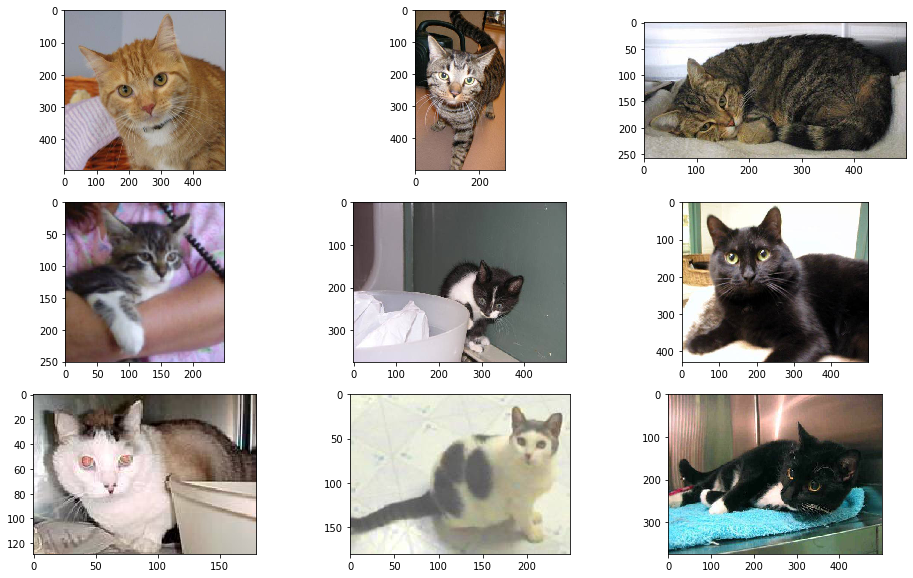

In [3]:
plt.figure(figsize=(16, 10))
for i in range(9):
    im = PIL.Image.open('DogsVsCats/input/train/cat.{}.jpg'.format(random.randint(1,200)))
    plt.subplot(3, 3,i+1)
    plt.imshow(im)
plt.show()


1. Так как изображения имеют разный размер, нам придется привести их к 1 размеру 
2. Изображения необходимо разделить по папкам test, train,validation и внутри этих папок создать две папки, отдельно для кошек и собак

In [6]:
#создадим папки и переменные для удобного указания дерикторий
os.mkdir('DogsVsCats/working/test/')
os.mkdir('DogsVsCats/working/test/cats')
os.mkdir('DogsVsCats/working/test/dogs')

os.mkdir('DogsVsCats/working/train/')
os.mkdir('DogsVsCats/working/train/cats')
os.mkdir('DogsVsCats/working/train/dogs')

os.mkdir('DogsVsCats/working/validation/')
os.mkdir('DogsVsCats/working/validation/cats')
os.mkdir('DogsVsCats/working/validation/dogs')

FileExistsError: [WinError 183] Невозможно создать файл, так как он уже существует: 'DogsVsCats/working/test/'

In [4]:
test_dir = 'DogsVsCats/working/test/'
cats_test_dir = 'DogsVsCats/working/test/cats'
dogs_test_dir = 'DogsVsCats/working/test/dogs'

train_dir = 'DogsVsCats/working/train/'
cats_train_dir = 'DogsVsCats/working/train/cats'
dogs_train_dir = 'DogsVsCats/working/train/dogs'

validation_dir = 'DogsVsCats/working/validation/'
cats_validation_dir = 'DogsVsCats/working/validation/cats'
dogs_validation_dir = 'DogsVsCats/working/validation/dogs'

In [9]:
# Скопируем изображения из исходной папки в новые папки с распределением на тренировку 7500 ,тест 2500 и проверку 2500
data = ['cat.{}.jpg'.format(i) for i in range(7500)]
for d in data:
    src = os.path.join('DogsVsCats/input/train/',d)
    dst = os.path.join(cats_train_dir,d)
    shutil.copyfile(src,dst)
    
data = ['cat.{}.jpg'.format(i) for i in range(7500,10000)]
for d in data:
    src = os.path.join('DogsVsCats/input/train/',d)
    dst = os.path.join(cats_test_dir,d)
    shutil.copyfile(src,dst)   
    
data = ['cat.{}.jpg'.format(i) for i in range(10000,12500)]
for d in data:
    src = os.path.join('DogsVsCats/input/train/',d)
    dst = os.path.join(cats_validation_dir,d)
    shutil.copyfile(src,dst)  
    
data = ['dog.{}.jpg'.format(i) for i in range(7500)]
for d in data:
    src = os.path.join('DogsVsCats/input/train/',d)
    dst = os.path.join(dogs_train_dir,d)
    shutil.copyfile(src,dst)
    
data = ['dog.{}.jpg'.format(i) for i in range(7500,10000)]
for d in data:
    src = os.path.join('DogsVsCats/input/train/',d)
    dst = os.path.join(dogs_test_dir,d)
    shutil.copyfile(src,dst)   
    
data = ['dog.{}.jpg'.format(i) for i in range(10000,12500)]
for d in data:
    src = os.path.join('DogsVsCats/input/train/',d)
    dst = os.path.join(dogs_validation_dir,d)
    shutil.copyfile(src,dst)      

In [5]:
print('train cat img: ', len(os.listdir(cats_train_dir)))
print('test cat img: ', len(os.listdir(cats_test_dir)))
print('validation cat img: ', len(os.listdir(cats_validation_dir)))

print('train dog img: ', len(os.listdir(dogs_train_dir)))
print('test dog img: ', len(os.listdir(dogs_test_dir)))
print('validation dog img: ', len(os.listdir(dogs_validation_dir)))

train cat img:  7500
test cat img:  2500
validation cat img:  2500
train dog img:  7500
test dog img:  2500
validation dog img:  2500


# 1. Создадим простую сверточную сеть и обучим её

Наша сверточная сеть будет состоять из 4 типов слоёв: Conv2D, MaxPooling2D

1. Conv2D:слой который выявляет локальные признаки из всего изображения  (Количество фильтров (32,64,128),(размер окна для фильтра(3,3)/(5,5)))
    input_shape принимает параметры (высота_изображения, ширина_изображения, каличество каналов (3 так как RGB))
    
2. MaxPooling2D  выбирает те фильтры из Conv2D, которые имеют максимальное значение, тем самым мы уменьшаем количество параметров 

3. Flatten объединяет все фильтры в единый вектор 
4. Последний слой Dense имеет 1 выходное значение , которое с помощью функции активации sigmoid, покажет нам вероятность принадлежности изображения к определенному классу 

In [11]:
model_1 = M.Sequential()
model_1.add(L.Conv2D(32,(3,3),activation='relu',
            input_shape=(150,150,3)))
model_1.add(L.MaxPooling2D((2,2)))
model_1.add(L.Conv2D(64,(3,3),activation='relu'))
model_1.add(L.MaxPooling2D((2,2)))
model_1.add(L.Conv2D(128,(3,3),activation='relu'))
model_1.add(L.MaxPooling2D((2,2)))
model_1.add(L.Conv2D(128,(3,3),activation='relu'))
model_1.add(L.MaxPooling2D((2,2)))
model_1.add(L.Flatten())
model_1.add(L.Dense(512,activation='relu'))
model_1.add(L.Dense(1,activation='sigmoid'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [12]:
model_1.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(lr=1e-4),
                metrics=['acc'])

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(150,150),
            batch_size = 20,
            class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(150,150),
            batch_size = 20,
            class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(150,150),
            batch_size = 20,
            class_mode = 'binary')

Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


Здесь можно увидеть что на трейне у нас 15000 образов, то есть по 7500 на 1 категорию

In [15]:
history_1 = model_1.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.samples//train_generator.batch_size,
            epochs=30,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples//test_generator.batch_size)

Epoch 1/30
750/750 [==============================] - 156s 208ms/step - loss: 0.5940 - acc: 0.6727 - val_loss: 0.5384 - val_acc: 0.7296
Epoch 2/30
750/750 [==============================] - 62s 82ms/step - loss: 0.4953 - acc: 0.7565 - val_loss: 0.4760 - val_acc: 0.7734
Epoch 3/30
750/750 [==============================] - 62s 83ms/step - loss: 0.4445 - acc: 0.7916 - val_loss: 0.4513 - val_acc: 0.7912
Epoch 4/30
750/750 [==============================] - 61s 81ms/step - loss: 0.4068 - acc: 0.8147 - val_loss: 0.4248 - val_acc: 0.8010
Epoch 5/30
750/750 [==============================] - 60s 80ms/step - loss: 0.3758 - acc: 0.8317 - val_loss: 0.4085 - val_acc: 0.8092
Epoch 6/30
750/750 [==============================] - 60s 80ms/step - loss: 0.3446 - acc: 0.8499 - val_loss: 0.3676 - val_acc: 0.8346
Epoch 7/30
750/750 [==============================] - 60s 80ms/step - loss: 0.3175 - acc: 0.8624 - val_loss: 0.3787 - val_acc: 0.8394
Epoch 8/30
750/750 [==============================] - 60s 80

In [16]:
model_1.save('dogs_vs_cats_model_1.h5')

### График обучения

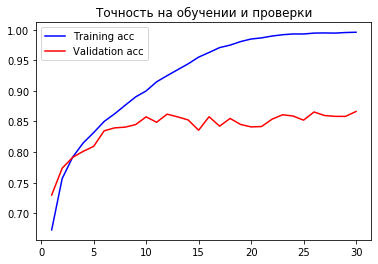

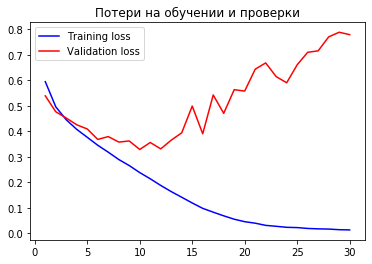

In [17]:
acc = history_1.history['acc']
val_acc = history_1.history['val_acc']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Точность на обучении и проверки')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Потери на обучении и проверки')
plt.legend()

plt.show()

По графикам видно что на 12 эпохе мы имеет наилуший результат по потерям и точности, далее наши показатели ухудшаются, что означаем что мы имеем дело с переобучением

# 2. Произведем аугментацию данных и посмотрим на изменение показателей сети при той же архитектуре

In [7]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(150,150),
            batch_size = 20,
            class_mode = 'binary')


Found 15000 images belonging to 2 classes.


In [18]:
history_2 = model_1.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.samples//train_generator.batch_size,
            epochs=30,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples//test_generator.batch_size)

model_1.save('dogs_vs_cats_model_2.h5')

Found 15000 images belonging to 2 classes.


C:\Users\Stark\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
750/750 [==============================] - 134s 178ms/step - loss: 0.5311 - acc: 0.7659 - val_loss: 0.3630 - val_acc: 0.8528
Epoch 2/30
750/750 [==============================] - 133s 177ms/step - loss: 0.4462 - acc: 0.7967 - val_loss: 0.3524 - val_acc: 0.8582
Epoch 3/30
750/750 [==============================] - 132s 176ms/step - loss: 0.4323 - acc: 0.8047 - val_loss: 0.3608 - val_acc: 0.8490
Epoch 4/30
750/750 [==============================] - 134s 178ms/step - loss: 0.4215 - acc: 0.8118 - val_loss: 0.3632 - val_acc: 0.8484
Epoch 5/30
750/750 [==============================] - 131s 175ms/step - loss: 0.4127 - acc: 0.8148 - val_loss: 0.3518 - val_acc: 0.8588
Epoch 6/30
750/750 [==============================] - 132s 176ms/step - loss: 0.4100 - acc: 0.8167 - val_loss: 0.3277 - val_acc: 0.8628
Epoch 7/30
750/750 [==============================] - 132s 177ms/step - loss: 0.4003 - acc: 0.8228 - val_loss: 0.3542 - val_acc: 0.8694
Epoch 8/30
750/750 [============================

### График обучения

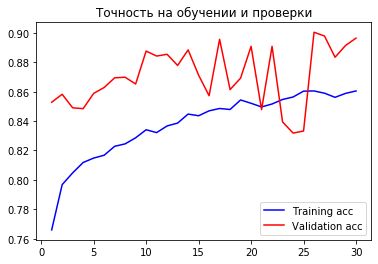

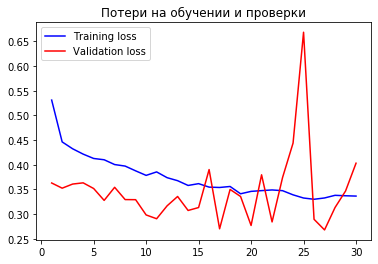

In [22]:
acc = history_2.history['acc']
val_acc = history_2.history['val_acc']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Точность на обучении и проверки')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Потери на обучении и проверки')
plt.legend()

plt.show()

#### Что мы имеет на данном этапе: 
Мы сделали аугментацию данных и получили улучшение результата на валидации (89% против 85%)

## 2.1 Добавим слой Dropout

In [28]:
model_21 = M.Sequential()
model_21.add(L.Conv2D(32,(3,3),activation='relu',
            input_shape=(150,150,3)))
model_21.add(L.MaxPooling2D((2,2)))
model_21.add(L.Conv2D(64,(3,3),activation='relu'))
model_21.add(L.MaxPooling2D((2,2)))
model_21.add(L.Conv2D(128,(3,3),activation='relu'))
model_21.add(L.MaxPooling2D((2,2)))
model_21.add(L.Conv2D(128,(3,3),activation='relu'))
model_21.add(L.MaxPooling2D((2,2)))
model_21.add(L.Flatten())
model_21.add(L.Dropout(0.25))
model_21.add(L.Dense(512,activation='relu'))
model_21.add(L.Dense(1,activation='sigmoid'))

model_21.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 128)      

In [29]:
model_21.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(lr=1e-4),
                metrics=['acc'])

In [30]:
history_21 = model_21.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.samples//train_generator.batch_size,
            epochs=30,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples//test_generator.batch_size)

model_21.save('dogs_vs_cats_model_21.h5')

Epoch 1/30
750/750 [==============================] - 137s 181ms/step - loss: 0.6787 - acc: 0.5639 - val_loss: 0.5755 - val_acc: 0.7054
Epoch 2/30
750/750 [==============================] - 138s 184ms/step - loss: 0.6164 - acc: 0.6513 - val_loss: 0.5496 - val_acc: 0.7164
Epoch 3/30
750/750 [==============================] - 141s 188ms/step - loss: 0.5722 - acc: 0.7001 - val_loss: 0.5462 - val_acc: 0.7200
Epoch 4/30
750/750 [==============================] - 132s 176ms/step - loss: 0.5543 - acc: 0.7123 - val_loss: 0.4904 - val_acc: 0.7750
Epoch 5/30
750/750 [==============================] - 132s 175ms/step - loss: 0.5403 - acc: 0.7275 - val_loss: 0.5807 - val_acc: 0.7244
Epoch 6/30
750/750 [==============================] - 132s 176ms/step - loss: 0.5237 - acc: 0.7394 - val_loss: 0.4418 - val_acc: 0.8026
Epoch 7/30
750/750 [==============================] - 132s 176ms/step - loss: 0.5052 - acc: 0.7521 - val_loss: 0.4795 - val_acc: 0.7942
Epoch 8/30
750/750 [============================

### График обучения

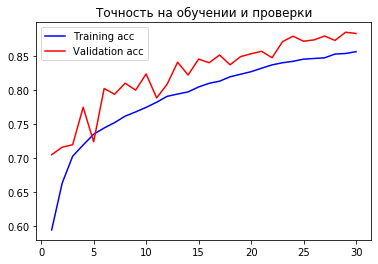

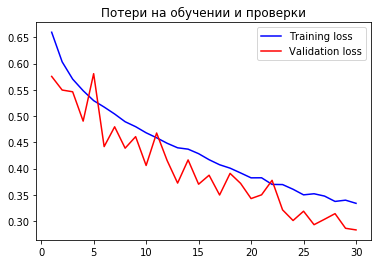

In [31]:
acc = history_21.history['acc']
val_acc = history_21.history['val_acc']
loss = history_21.history['loss']
val_loss = history_21.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Точность на обучении и проверки')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Потери на обучении и проверки')
plt.legend()

plt.show()

## 2.2 Добавим регуляризацию L1_L2

In [50]:
model_22 = M.Sequential()
model_22.add(L.Conv2D(32,(3,3),activation='relu',
            input_shape=(150,150,3)))
model_22.add(L.MaxPooling2D((2,2)))
model_22.add(L.Conv2D(64,(3,3),activation='relu'))
model_22.add(L.MaxPooling2D((2,2)))
model_22.add(L.Conv2D(128,(3,3),activation='relu'))
model_22.add(L.MaxPooling2D((2,2)))
model_22.add(L.Conv2D(128,(3,3),activation='relu'))
model_22.add(L.MaxPooling2D((2,2)))
model_22.add(L.Flatten())
model_22.add(L.Dropout(0.25))
model_22.add(L.Dense(512,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.0000001,l2=0.0000001)))
model_22.add(L.Dense(1,activation='sigmoid'))

model_22.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 15, 15, 128)     

In [51]:
model_22.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(lr=1e-4),
                metrics=['acc'])

In [52]:
history_22 = model_22.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.samples//train_generator.batch_size,
            epochs=30,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples//test_generator.batch_size)

model_22.save('dogs_vs_cats_model_22.h5')

Epoch 1/30
750/750 [==============================] - 152s 201ms/step - loss: 0.6850 - acc: 0.5473 - val_loss: 0.6034 - val_acc: 0.6780
Epoch 2/30
750/750 [==============================] - 140s 186ms/step - loss: 0.6146 - acc: 0.6575 - val_loss: 0.5615 - val_acc: 0.7124
Epoch 3/30
750/750 [==============================] - 140s 186ms/step - loss: 0.5878 - acc: 0.6823 - val_loss: 0.5005 - val_acc: 0.7650
Epoch 4/30
750/750 [==============================] - 140s 187ms/step - loss: 0.5657 - acc: 0.7067 - val_loss: 0.5078 - val_acc: 0.7588
Epoch 5/30
750/750 [==============================] - 140s 186ms/step - loss: 0.5470 - acc: 0.7302 - val_loss: 0.4924 - val_acc: 0.7662
Epoch 6/30
750/750 [==============================] - 140s 187ms/step - loss: 0.5267 - acc: 0.7360 - val_loss: 0.4580 - val_acc: 0.7956
Epoch 7/30
750/750 [==============================] - 140s 187ms/step - loss: 0.5202 - acc: 0.7456 - val_loss: 0.4509 - val_acc: 0.7940
Epoch 8/30
750/750 [============================

### График обучения

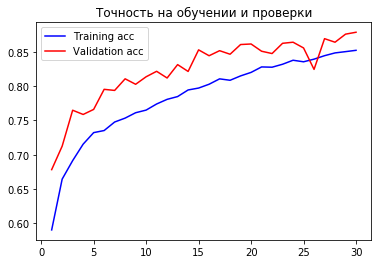

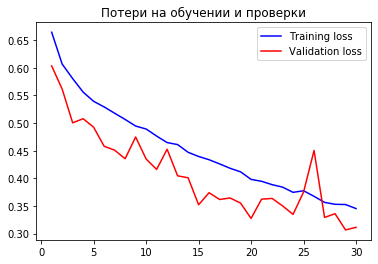

In [53]:
acc = history_22.history['acc']
val_acc = history_22.history['val_acc']
loss = history_22.history['loss']
val_loss = history_22.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Точность на обучении и проверки')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Потери на обучении и проверки')
plt.legend()

plt.show()

# 3.  Применение feature extraction

Метод при котором мы будем использовать заранее подготовленную сеть, в нашем случае готовая сеть уже находиться в keras.applications я буду использовать в качестве примера сеть VGG16, но так же можно использовать и другие сети, например: 
- Xception
- Inception V3
- ResNet50
- VGG16
- VGG19
- MobileNet

Когда мы говорим о применении feature extraction, если два способа реализации: 
1. Заранее прогнать все наши данные через готовую сеть и на выходе получить массив NumPy, который в дальнейшем можно подать на полносвязный классификатор, из плюсов можно отметить низкие затраты ресурсов, из минусов, то что мы не сможем использовать расширение данных 
2. Использовать готовую модель совместно с полносвязным классификатором, такое решение будет более дорогим по ресурсам, но зато мы сможем использовать расширение данных. Так же тут важно заморозить основу сети base_model.trainable = False

Я же здесь воспользуюсь вторым способом, возможно позже протестирую и первый способ 

In [8]:
from tensorflow.keras.applications import VGG16

base_model_16 = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))
base_model_16.trainable = False

In [9]:
model_3 = M.Sequential()
model_3.add(base_model_16)
model_3.add(L.Flatten())
model_3.add(L.Dropout(0.25))
model_3.add(L.Dense(512,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.0000001,l2=0.0000001)))
model_3.add(L.Dense(1, activation='sigmoid'))
model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
model_3.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(lr=1e-4),
                metrics=['acc'])

In [11]:
history_3 = model_3.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.samples//train_generator.batch_size,
            epochs=10,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples//test_generator.batch_size)
model_3.save('dogs_vs_cats_model_3.h5')

C:\Users\Stark\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
750/750 [==============================] - 200s 253ms/step - loss: 0.5152 - acc: 0.7519 - val_loss: 0.3730 - val_acc: 0.8454
Epoch 2/10
750/750 [==============================] - 166s 222ms/step - loss: 0.3684 - acc: 0.8372 - val_loss: 0.2537 - val_acc: 0.8994
Epoch 3/10
750/750 [==============================] - 181s 242ms/step - loss: 0.3478 - acc: 0.8453 - val_loss: 0.2793 - val_acc: 0.8914
Epoch 4/10
750/750 [==============================] - 189s 252ms/step - loss: 0.3446 - acc: 0.8477 - val_loss: 0.2652 - val_acc: 0.8932
Epoch 5/10
750/750 [==============================] - 188s 251ms/step - loss: 0.3420 - acc: 0.8526 - val_loss: 0.2676 - val_acc: 0.8932
Epoch 6/10
750/750 [==============================] - 195s 260ms/step - loss: 0.3334 - acc: 0.8547 - val_loss: 0.2588 - val_acc: 0.8948
Epoch 7/10
750/750 [==============================] - 187s 249ms/step - loss: 0.3337 - acc: 0.8550 - val_loss: 0.2713 - val_acc: 0.8984
Epoch 8/10
750/750 [============================

### График обучения

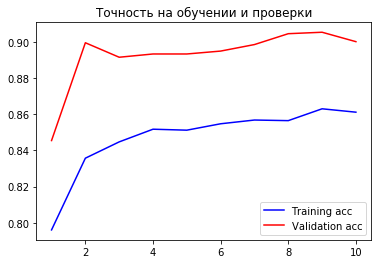

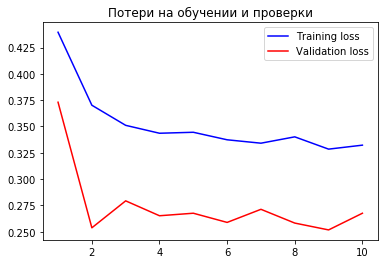

In [13]:
acc = history_3.history['acc']
val_acc = history_3.history['val_acc']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Точность на обучении и проверки')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Потери на обучении и проверки')
plt.legend()

plt.show()

# 4. Fine Tuning, дообучение модели 

Данная процедура похожа на прошлую за тем исключением что мы возьмем готовую сеть, заморозим в ней нижние слои а верние разморозим, что бы мы имели возможность дообучить модель на наших данных и использовать уже дообученную сеть в нашей задаче.

Так как нижние слои сверточной сети(основы), выделяют из образов более обощенные признаки, имеет смысл их заморозить, а верхние слои, которые выделяют более конкрентые признаки из образов имеет смысл дообучить на новую задачу

In [14]:
base_model_16 = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))
base_model_16.trainable = True

trainable = False
for layer in base_model_16.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    if trainable:
        layer.trainable == True
    else:
        layer.trainable = False        

In [15]:
model_4 = M.Sequential()
model_4.add(base_model_16)
model_4.add(L.Flatten())
model_4.add(L.Dropout(0.25))
model_4.add(L.Dense(512,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.0000001,l2=0.0000001)))
model_4.add(L.Dense(1, activation='sigmoid'))
model_4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 11,274,753
Non-trainable params: 7,635,264
_________________________________________________________________


In [16]:
model_4.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(lr=1e-4),
                metrics=['acc'])

In [20]:
history_4 = model_4.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.samples//train_generator.batch_size,
            epochs=15,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples//test_generator.batch_size)
model_4.save('dogs_vs_cats_model_4.h5')

Epoch 1/15
750/750 [==============================] - 194s 259ms/step - loss: 0.2131 - acc: 0.9279 - val_loss: 0.2522 - val_acc: 0.9462
Epoch 2/15
750/750 [==============================] - 217s 289ms/step - loss: 0.2153 - acc: 0.9292 - val_loss: 0.2503 - val_acc: 0.9500
Epoch 3/15
750/750 [==============================] - 206s 274ms/step - loss: 0.2157 - acc: 0.9295 - val_loss: 0.3732 - val_acc: 0.9128
Epoch 4/15
750/750 [==============================] - 221s 294ms/step - loss: 0.2149 - acc: 0.9321 - val_loss: 0.2933 - val_acc: 0.9452
Epoch 5/15
750/750 [==============================] - 232s 310ms/step - loss: 0.2427 - acc: 0.9319 - val_loss: 0.3436 - val_acc: 0.9404
Epoch 6/15
750/750 [==============================] - 228s 304ms/step - loss: 0.2201 - acc: 0.9314 - val_loss: 0.3746 - val_acc: 0.9468
Epoch 7/15
750/750 [==============================] - 226s 301ms/step - loss: 0.2433 - acc: 0.9339 - val_loss: 0.6772 - val_acc: 0.8804
Epoch 8/15
750/750 [============================

### График обучения

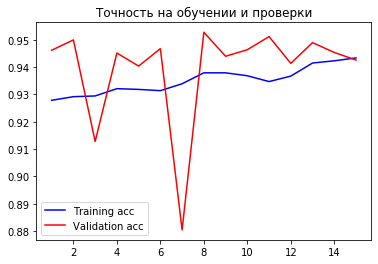

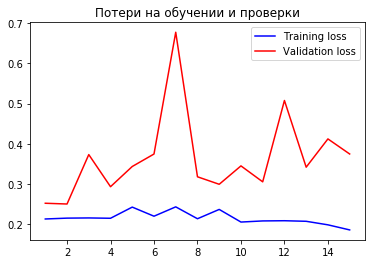

In [21]:
acc = history_4.history['acc']
val_acc = history_4.history['val_acc']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(1,len(acc)+1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Точность на обучении и проверки')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Потери на обучении и проверки')
plt.legend()

plt.show()

## 4.1 Fine Tuning + BatchNormalization + Dense(256)

In [29]:
model_5 = M.Sequential()
model_5.add(base_model_16)
model_5.add(L.Flatten())
model_5.add(L.BatchNormalization())
model_5.add(L.Dropout(0.25))
model_5.add(L.Dense(256,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.0000001,l2=0.0000001)))
model_5.add(L.Dense(1, activation='sigmoid'))
model_5.summary()


model_5.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
dropout_3 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,845,121
Trainable params: 9,193,473
Non-trainable params: 7,651,648
___________________________________

In [31]:
model_5.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(lr=1e-5),
                metrics=['acc'])

In [32]:
history_5 = model_5.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.samples//train_generator.batch_size,
            epochs=15,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples//test_generator.batch_size)
model_5.save('dogs_vs_cats_model_5.h5')

Epoch 1/15
750/750 [==============================] - 189s 249ms/step - loss: 0.3831 - acc: 0.8450 - val_loss: 0.1432 - val_acc: 0.9484
Epoch 2/15
750/750 [==============================] - 194s 258ms/step - loss: 0.1402 - acc: 0.9492 - val_loss: 0.1332 - val_acc: 0.9540
Epoch 3/15
750/750 [==============================] - 185s 246ms/step - loss: 0.1336 - acc: 0.9477 - val_loss: 0.1717 - val_acc: 0.9478
Epoch 4/15
750/750 [==============================] - 199s 266ms/step - loss: 0.1284 - acc: 0.9524 - val_loss: 0.1808 - val_acc: 0.9536
Epoch 5/15
750/750 [==============================] - 280s 373ms/step - loss: 0.1186 - acc: 0.9536 - val_loss: 0.1737 - val_acc: 0.9544
Epoch 6/15
750/750 [==============================] - 282s 375ms/step - loss: 0.1166 - acc: 0.9578 - val_loss: 0.1672 - val_acc: 0.9512
Epoch 7/15
750/750 [==============================] - 328s 436ms/step - loss: 0.1195 - acc: 0.9584 - val_loss: 0.1552 - val_acc: 0.9546
Epoch 8/15
750/750 [============================

### График обучения

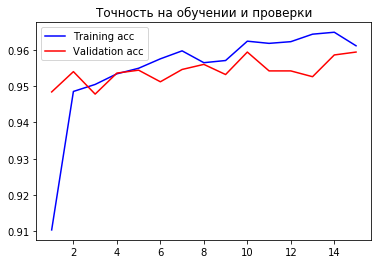

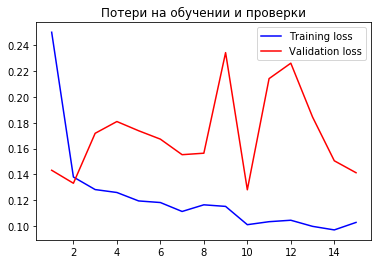

In [33]:
acc = history_5.history['acc']
val_acc = history_5.history['val_acc']
loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

epochs = range(1,len(acc)+1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Точность на обучении и проверки')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Потери на обучении и проверки')
plt.legend()

plt.show()

## 4.1 Fine Tuning + BatchNormalization + Dense(128)

In [34]:
model_6 = M.Sequential()
model_6.add(base_model_16)
model_6.add(L.Flatten())
model_6.add(L.BatchNormalization())
model_6.add(L.Dropout(0.25))
model_6.add(L.Dense(128,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.0000001,l2=0.0000001)))
model_6.add(L.Dense(1, activation='sigmoid'))
model_6.summary()


model_6.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8192)              32768     
_________________________________________________________________
dropout_4 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 15,796,289
Trainable params: 8,144,641
Non-trainable params: 7,651,648
___________________________________

In [35]:
model_6.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(lr=1e-5),
                metrics=['acc'])

In [36]:
history_6 = model_6.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.samples//train_generator.batch_size,
            epochs=15,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples//test_generator.batch_size)
model_6.save('dogs_vs_cats_model_6.h5')

Epoch 1/15
750/750 [==============================] - 179s 236ms/step - loss: 0.2827 - acc: 0.8830 - val_loss: 0.1170 - val_acc: 0.9556
Epoch 2/15
750/750 [==============================] - 190s 253ms/step - loss: 0.1079 - acc: 0.9592 - val_loss: 0.1341 - val_acc: 0.9540
Epoch 3/15
750/750 [==============================] - 199s 266ms/step - loss: 0.1079 - acc: 0.9603 - val_loss: 0.1219 - val_acc: 0.9570
Epoch 4/15
750/750 [==============================] - 201s 267ms/step - loss: 0.1045 - acc: 0.9621 - val_loss: 0.1229 - val_acc: 0.9558
Epoch 5/15
750/750 [==============================] - 202s 268ms/step - loss: 0.1006 - acc: 0.9622 - val_loss: 0.1330 - val_acc: 0.9590
Epoch 6/15
750/750 [==============================] - 205s 273ms/step - loss: 0.0995 - acc: 0.9631 - val_loss: 0.1269 - val_acc: 0.9592
Epoch 7/15
750/750 [==============================] - 210s 280ms/step - loss: 0.0987 - acc: 0.9645 - val_loss: 0.1247 - val_acc: 0.9574
Epoch 8/15
750/750 [============================

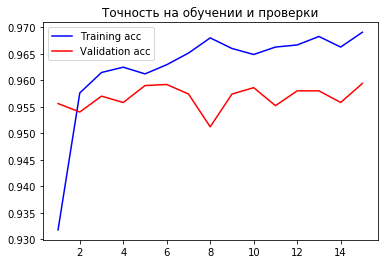

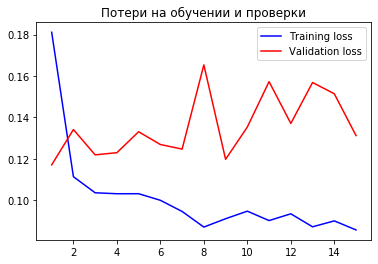

In [37]:
acc = history_6.history['acc']
val_acc = history_6.history['val_acc']
loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

epochs = range(1,len(acc)+1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Точность на обучении и проверки')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Потери на обучении и проверки')
plt.legend()

plt.show()